<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Yogith_L_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'

cs_data = pd.read_csv(url_cs)

#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp

#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

#giving our model a way to know which difference corresponds to which amino acid
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

Output()

Output()

Output()

Output()

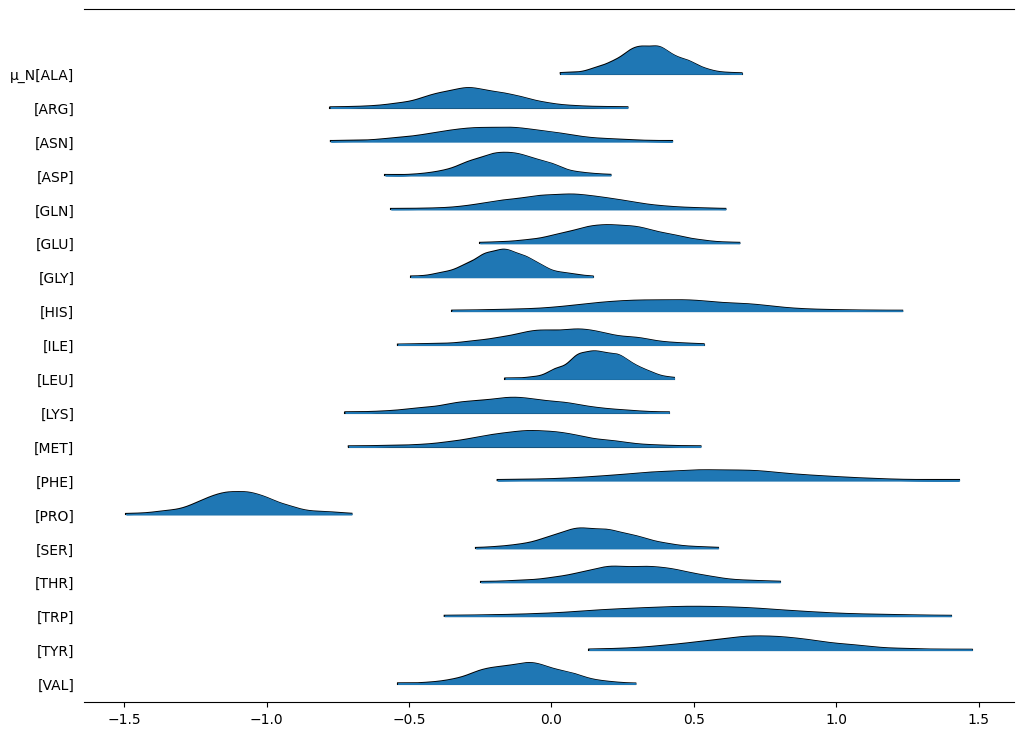

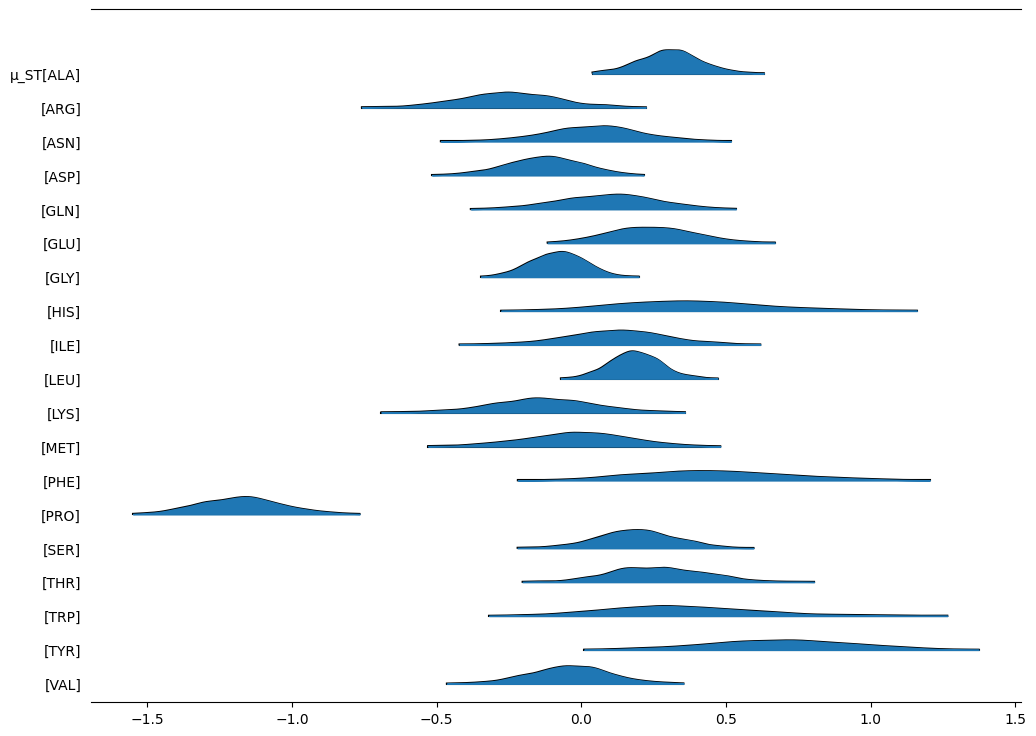

In [4]:
#CODE FOR NORMAL CHEMICAL SHIFT HIERARCHICAL MODEL

with pm.Model(coords=aa_coords) as cs_h_model_N:

    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
      μ_mu_N = pm.Normal('μ_mu_N', mu = 0, sigma = 10)
      μ_sd_N = pm.HalfNormal('μ_sd_N', sigma = 10)

      # priors. There is a different prior for each amino acid,
      #but now the μ priors 'talk' to one another through μ_mu and μ_sd
      μ_N = pm.Normal('μ_N',
                  mu = μ_mu_N,
                  sigma = μ_sd_N,
                  dims = "aa")

      σ_N = pm.HalfNormal('σ_N', sigma = 10,
                      dims = "aa")

      #likelihood; same as before
      y_N = pm.Normal('y_N',
                  mu = μ_N[aa_idx],
                  sigma = σ_N[aa_idx],
                  observed = cs_data.diff_TminusE)

      #cs for chemshift, h for heirarchical
      idata_cs_h_N = pm.sample()
      axes = az.plot_forest(idata_cs_h_N, kind= "ridgeplot",
                      var_names='μ_N',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

#CODE FOR STUDENTT CHEMICAL SHIFT HIERARCHICAL MODEL

with pm.Model(coords=aa_coords) as cs_h_model_ST:

    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids

    #with a high nu, this graph will be similar to the normal dist.
    μ_mu_ST = pm.StudentT('μ_mu_ST', nu=10^6, mu = 0, sigma = 10)
    μ_sd_ST = pm.HalfStudentT('μ_sd_ST', nu=10^6, sigma = 10)
    μ_nu_ST = pm.HalfStudentT('μ_nu_ST', nu=10^6, sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ_ST = pm.StudentT('μ_ST',
                  nu= μ_nu_ST,
                  mu = μ_mu_ST,
                  sigma = μ_sd_ST,
                  dims = "aa")

    σ_ST = pm.HalfStudentT('σ_ST', nu=10^6, sigma = 10,
                      dims = "aa")

    v_ST= pm.HalfStudentT('v_ST', nu=10^6, sigma = 10,
                      dims = "aa")


    #likelihood; same as before
    y_ST = pm.StudentT('y_ST',
                  nu= v_ST[aa_idx],
                  mu = μ_ST[aa_idx],
                  sigma = σ_ST[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h_ST = pm.sample()

    axes = az.plot_forest(idata_cs_h_ST, kind="ridgeplot",
                      var_names='μ_ST',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Since I wasn't sure how I wanted to create my priors for the STUDENTT likelihood, I decided to match its appearance to my NORMAL likelihood.
So, when creating my StudentT model's priors, I used large values of nu (10*6) so the distribution approaches normality; this is because as degrees of freedom approaches infinity, the curve becomes more normal.

Consequently, the graphs of both the StudentT and Normal distributions appeared largely similar. There are some minor differences, though: in the StudentT plot VAL is shifted slightly to the left, LYS looks less normal, and the peaks of some other amino acids are compressed slightly.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

(-8.0, 8.0)

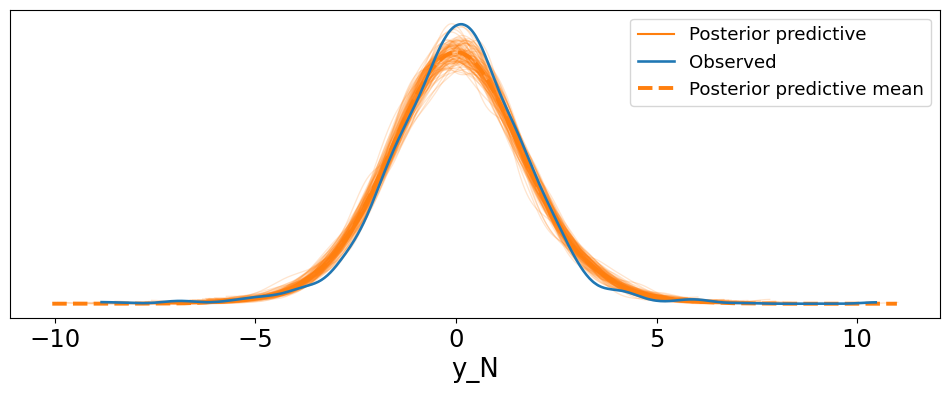

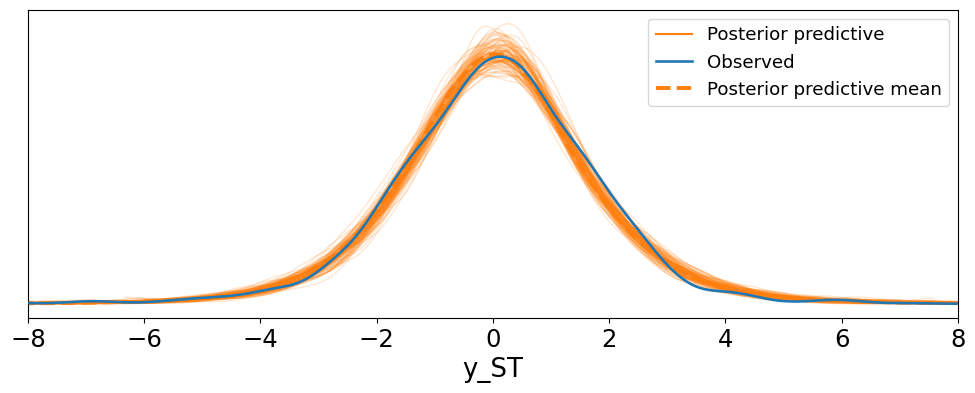

In [5]:
#Normal Posterior
pm.sample_posterior_predictive(idata_cs_h_N, model=cs_h_model_N, extend_inferencedata=True)
az.plot_ppc(idata_cs_h_N, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

#StudentT Posterior
pm.sample_posterior_predictive(idata_cs_h_ST, model=cs_h_model_ST, extend_inferencedata=True)
ST=az.plot_ppc(idata_cs_h_ST, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ST.set_xlim(-8, 8)


Both likelihoods fit the data extremely well, but they have minor issues. The NORMAL distribution overestimates values near 0 and the STUDENTT distribution underestimates values near 0. Ultimately, though, I would say the STUDENTT distribution is a slightly better fit for the data because it's less off from the posterior predictive mean.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [6]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [7]:
with pm.Model(coords = sccr_coords) as sccr_model:

  μ_p = pm.Beta('μ_p', mu = .1, nu = 45 , dims = "pos") #mu=.1 because out of all the shots we score, I'd assume scoring a goal is pretty low chance if that makes sense
  ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
  θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

  yog = pm.Binomial('gs',
                  n = sccr_data.shots.values, #shots for each player
                  p = θ, #guess of goals per shot
                  observed = sccr_data.goals.values) #goals per player

  idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and that on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

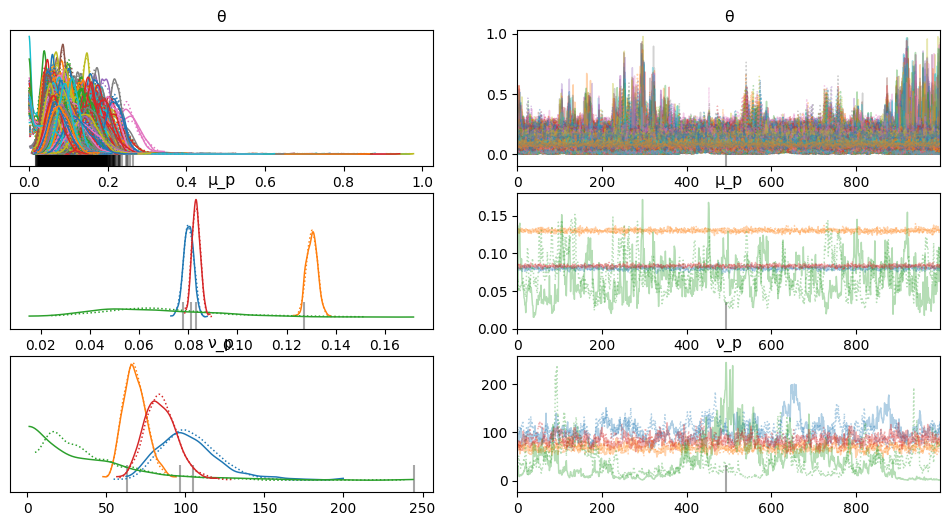

In [8]:
az.plot_trace(idata_sccr)

In [9]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.003 1.004 0.9997 1.0 ... 1.006 1.0 1.001
    μ_p      (pos) float64 32B 1.002 0.9999 1.015 1.001
    ν_p      (pos) float64 32B 1.045 1.003 1.018 1.005

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model_hierarchical:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    yog = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_hierarchical = pm.sample(target_accept = 0.95)

Output()

Output()

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

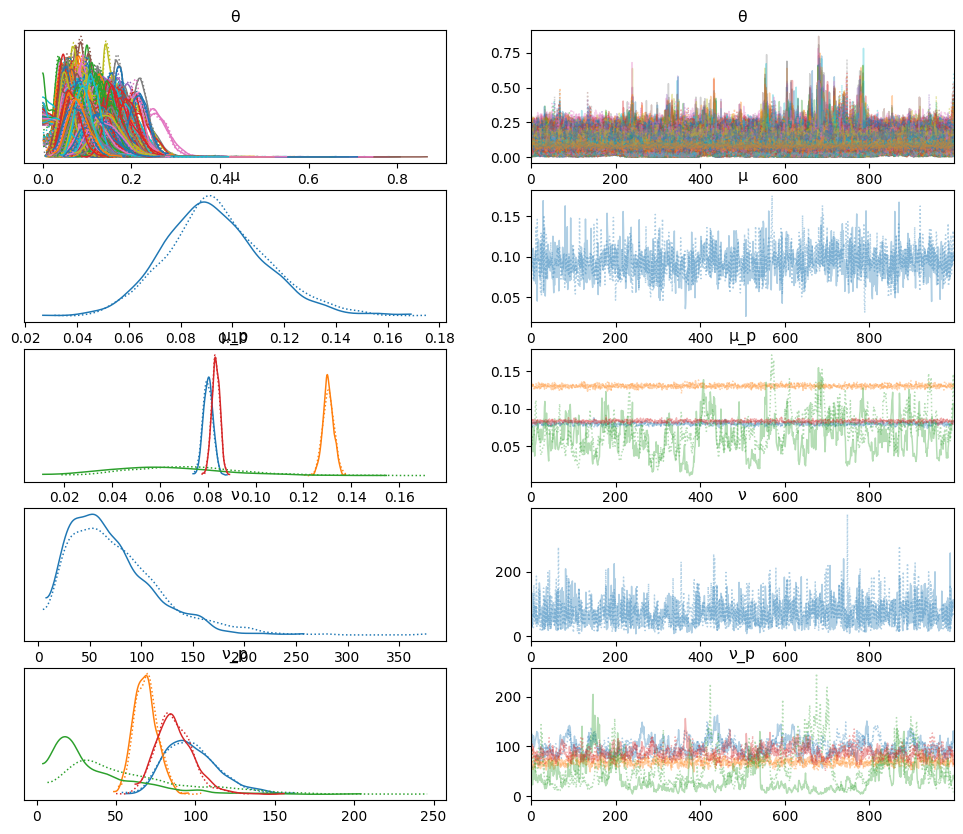

In [11]:
az.plot_trace(idata_sccr_hierarchical)

In [12]:
az.rhat(idata_sccr_hierarchical)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 1.0 1.0 ... 1.001 1.001 1.001
    μ        float64 8B 1.011
    μ_p      (pos) float64 32B 1.004 1.003 1.098 0.9998
    ν        float64 8B 1.005
    ν_p      (pos) float64 32B 1.012 1.004 1.126 1.004

Initially, the first difference I noticed is that the hierarchical model has 2 more graphs; this can be explained by the 2 extra hyperpriors. The graphs that they do share (μ_p, v_p, and $\theta$) all appear extremely similar. The hierarchical model does seem to fit the data better because it tends to underestimate less (comparing both model's v_p graph).  

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

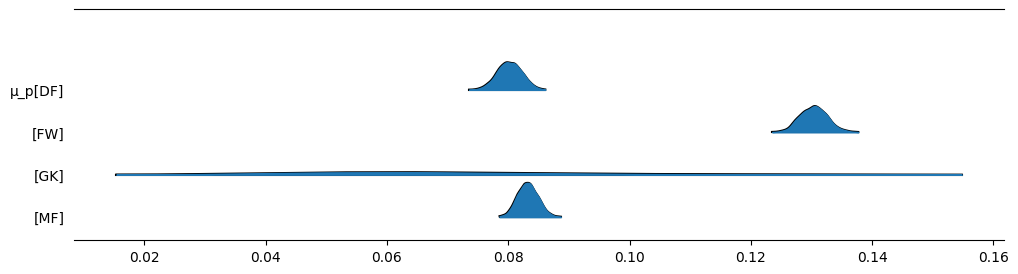

In [13]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

array([<Axes: >], dtype=object)

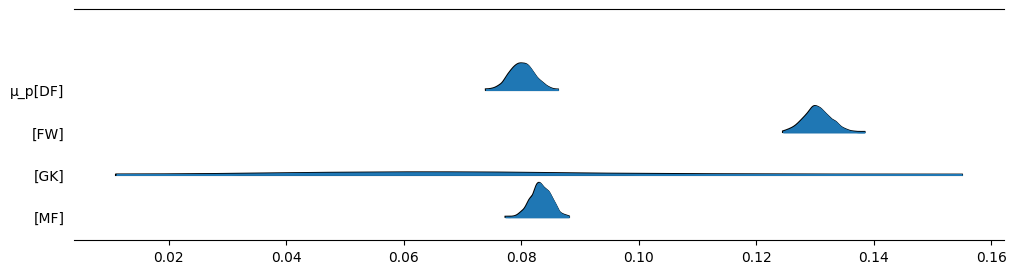

In [14]:
az.plot_forest(idata_sccr_hierarchical, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Both appear virtually the same except the hierarchical model's "mini-graphs" seem to be more smooth.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [20]:
url_sccr_NGK = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data_NGK = pd.read_csv(url_sccr_NGK)

NGK= sccr_data_NGK.query(' position != "GK" ')
NGK['position'] = NGK['position'].astype('category')

pos_idx = NGK.position.cat.codes.values
pos_codes = NGK.position.cat.categories
sccr_coords_NGK = {'pos': pos_codes}

sccr_coords_NGK

<ipython-input-20-7f963ecfb5ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NGK['position'] = NGK['position'].astype('category')


{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}

In [23]:
with pm.Model(coords = sccr_coords) as sccr_model_hierarchical_NGK:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    yog = pm.Binomial('gs',
                    n = NGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = NGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_hierarchical_NGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9997 1.0 0.9999 1.0 ... 1.0 0.9999 1.0
    μ        float64 8B 1.001
    μ_p      (pos) float64 32B 1.006 1.0 1.004 1.005
    ν        float64 8B 1.002
    ν_p      (pos) float64 32B 1.053 1.0 1.002 1.001

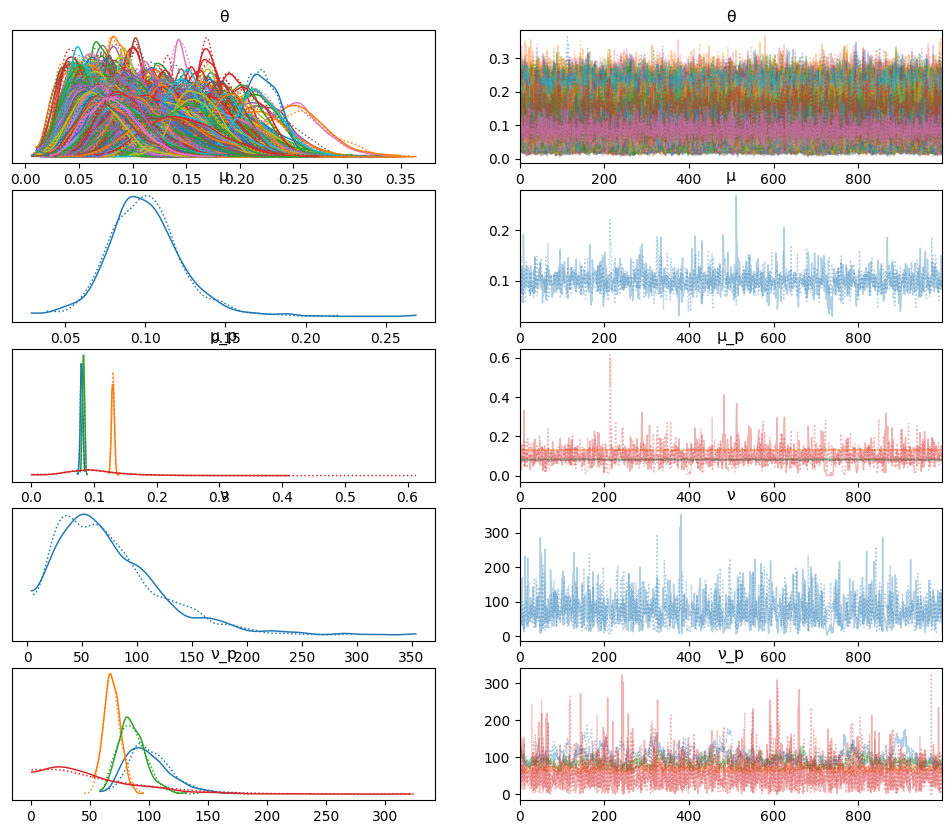

In [24]:
az.plot_trace(idata_sccr_hierarchical_NGK)
az.rhat(idata_sccr_hierarchical_NGK)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 1.0 1.0 ... 1.001 1.001 1.001
    μ        float64 8B 1.011
    μ_p      (pos) float64 32B 1.004 1.003 1.098 0.9998
    ν        float64 8B 1.005
    ν_p      (pos) float64 32B 1.012 1.004 1.126 1.004

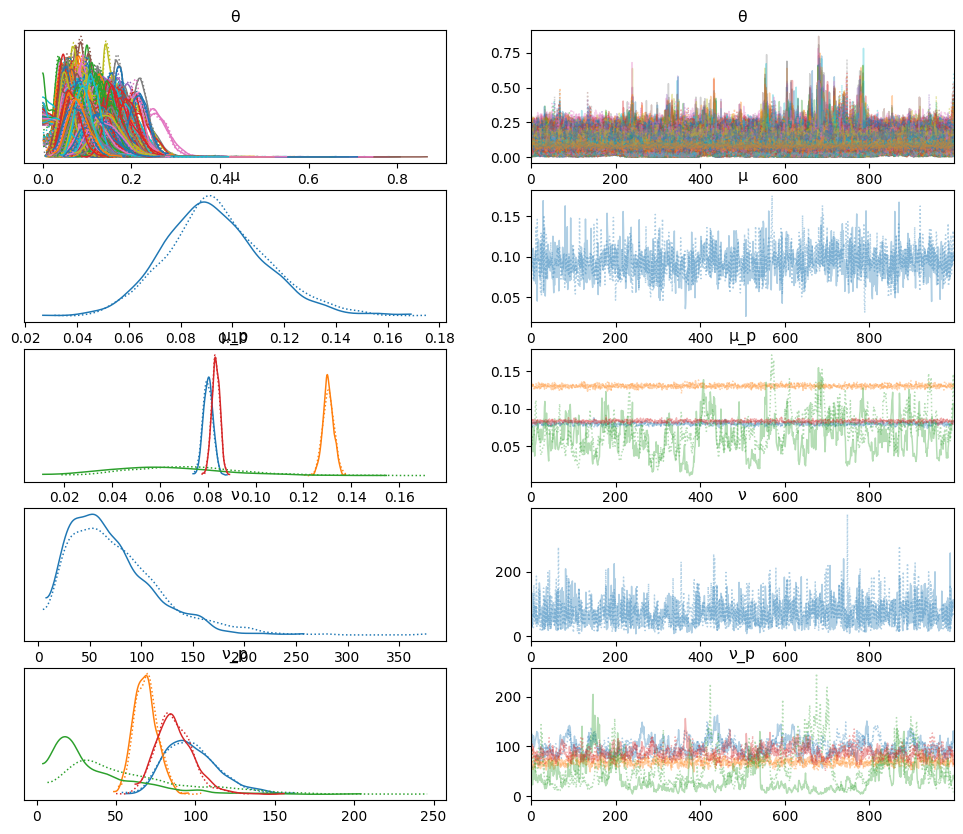

In [25]:
az.plot_trace(idata_sccr_hierarchical)
az.rhat(idata_sccr_hierarchical)

Comparison: The generic shapes for a majority of the models' graphs are alike, however, the red colored curve is consistently different in both models. The flatter red curve in the NGK model may represent a decrease in the total number of goals. Additionally, the complexity of the model with GKs is more than the one without. This is because PYMC has less positions to take into account.

- Which model was easier for pymc to process?
  
  Since the model with GKs is more complex, it makes sense for the models with no GKs (NGK) to process easier.

- What do we lose by dropping Gks from the data set? What do we gain?

  By dropping GKs from the data set we lose information about the frequency of shots that the position takes and how many of those shots they score. In return, we get better processing speeds and distributions that have slightly better trends because GKs are relative outliers compared to other positions.  
